# Iceberg ❤️ Python

In [ ]:
CI = False

In [ ]:
# Skip this notebook execution in CI because it hits non-public buckets
if CI:
    import sys

    sys.exit()

In [ ]:
#### SETUP - run to set up the notebook

import pathlib
import shutil

shutil.rmtree("/tmp/warehouse")
pathlib.Path("/tmp/warehouse").mkdir(exist_ok=True)

In [ ]:
!pip install 'pyiceberg[sql]'
!pip install 'daft[ray]' polars pandas
!pip install ray==2.20.0
!pip install sqlalchemy ipywidgets boto3 mypy_boto3_glue

## PyIceberg basics - Catalogs, Namespaces and Tables

Let's run through a simple end-to-end example of Reading/Writing to Iceberg.

### Catalogs

Catalogs are records of where to find iceberg tables. PyIceberg adds support for connecting to many catalogs such as AWS Glue, Iceberg REST and more.

For the purposes of this tutorial, let's use SQLite as a local catalog so we can run everything on our machine!

In [ ]:
from pyiceberg.catalog.sql import SqlCatalog

warehouse_path = "/tmp/warehouse"
catalog = SqlCatalog(
    "default",
    **{
        "uri": f"sqlite:///{warehouse_path}/pyiceberg_catalog.db",
        "warehouse": f"file://{warehouse_path}",
    },
)

### Namespaces

Namespaces are collections of tables under a Catalog

In [ ]:
catalog.create_namespace("my_namespace")

### Tables

Tables can be created in a catalog. Let's go ahead and create a table in our catalog which does not yet contain any data.

In [ ]:
from pyiceberg.schema import IntegerType, NestedField, Schema, StringType

SCHEMA = Schema(
    NestedField(1, "name", StringType(), required=False),
    NestedField(2, "age", IntegerType(), required=False),
)

table = catalog.create_table("my_namespace.my_friends", schema=SCHEMA)

In [ ]:
table

In [ ]:
# TODO: Let's show the data in /tmp/warehouse

In [ ]:
import daft

df = daft.from_pydict(
    {
        "name": ["jay", "sammy", "brian"],
        "age": [30, 31, 32],
    }
)

df

In [ ]:
df.write_iceberg(table, mode="overwrite")

## Reading the Table

PyIceberg provides various options for reading the tables. Let's take a look at a few.

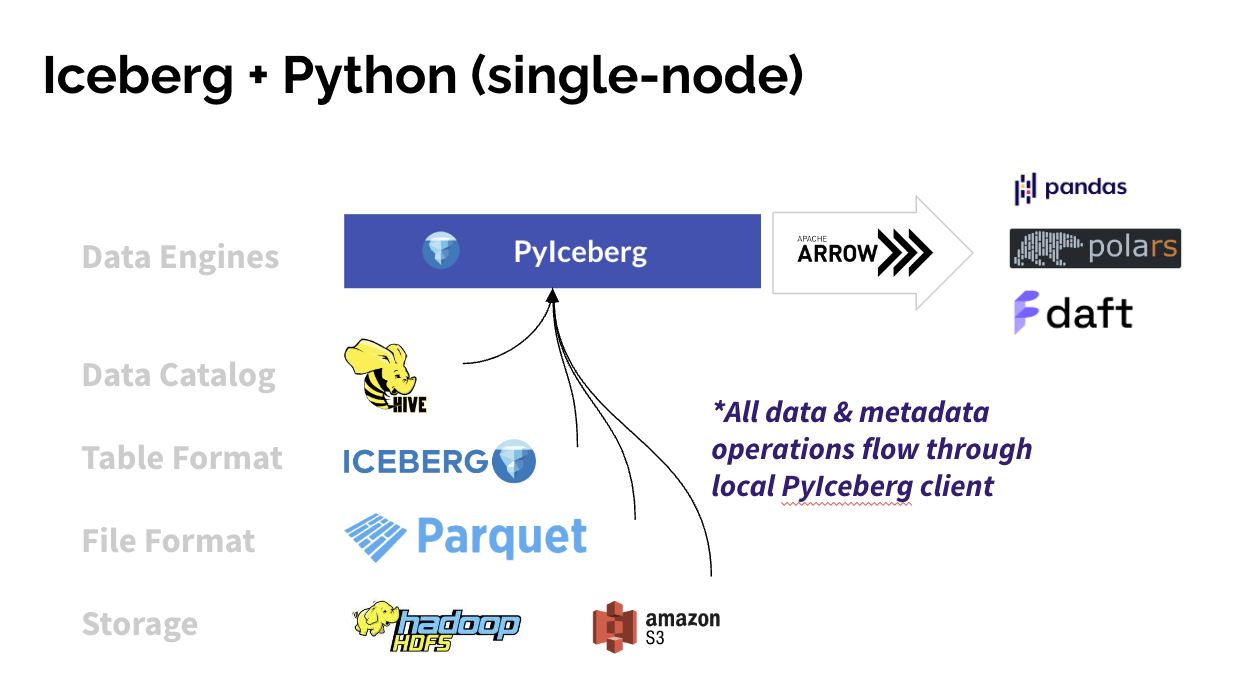

In [ ]:
# Pandas: eager materialization
table.scan().to_pandas()

In [ ]:
# Polars: lazy materialization
import polars as pl

pl.scan_iceberg(table)

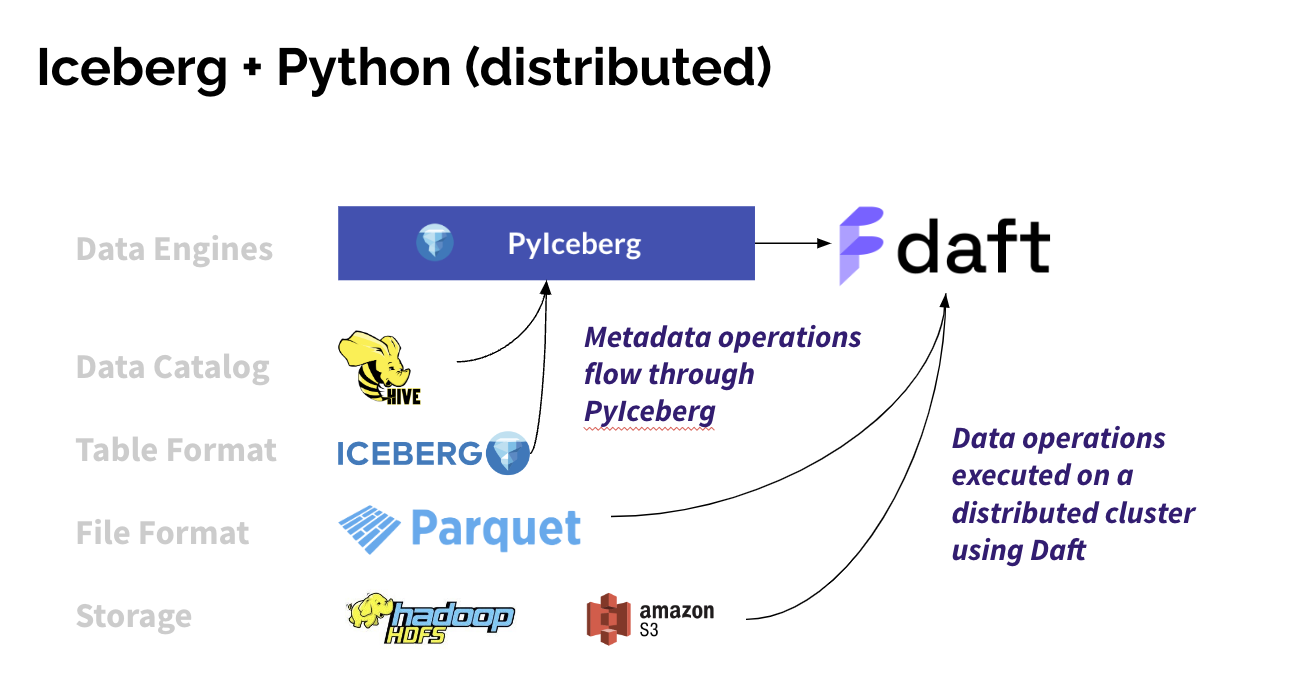

In [ ]:
# Daft: lazy materialization

daft.read_iceberg(table)  # equivalent to: `table.to_daft()`

In [ ]:
# Daft: distributed reads

daft.read_iceberg(table).explain(True)

## Working with BIG iceberg tables

When working with larger tables, we will want to run our workload in the cloud!

1. Increase I/O throughput from cloud storage by running in the same cloud region
2. Scale horizontally to maximize I/O throughput (each machine has physical hardware limitations on how fast it can read data from network)
3. Scale vertically/horizontally to increase available computational resources

In [ ]:
from pyiceberg.catalog.glue import GlueCatalog

catalog = GlueCatalog("my_glue_catalog")
table = catalog.load_table("tpch_iceberg_sf1000.lineitem")

In [ ]:
table

In [ ]:
df = daft.read_iceberg(table)
df.show()

In [ ]:
import datetime

df = df.where(df["L_SHIPDATE"] < datetime.date(1996, 1, 1))
aggregated_df = df.groupby("L_SHIPDATE").agg([daft.col("L_EXTENDEDPRICE").sum()])

In [ ]:
aggregated_df

In [ ]:
aggregated_df.explain(True)

**NOTE:**

The plan produced above by Daft indicates that the query will scan a large number of bytes (tens of gigabytes!) over a large number of files (about 280 files).

Running this on our current machine would not be a good idea. The data is fairly large and will take a long time to download via my office WiFi. Let's try a better option!

## Run on a distributed cluster

In [ ]:
import ray

ray.init(address="ray://localhost:10001")

In [ ]:
ray.cluster_resources()

In [ ]:
import daft

daft.context.set_runner_ray(address="ray://localhost:10001")

In [ ]:
import datetime

from pyiceberg.catalog.glue import GlueCatalog

catalog = GlueCatalog("my_glue_catalog")
table = catalog.load_table("tpch_iceberg_sf1000.lineitem")

df = daft.read_iceberg(table)
df = df.where(df["L_SHIPDATE"] < datetime.date(1996, 1, 1))
aggregated_df = df.groupby("L_SHIPDATE").agg([daft.col("L_EXTENDEDPRICE").sum()])

In [ ]:
%%time

aggregated_df.sort("L_SHIPDATE").collect()

## Recap!

1. **No JVM!**: none of the code in this tutorial involved the JVM at all
2. **Fast Locally**: incredibly easy to get started with iceberg with simple `pip` installations of open-sourced Python libraries
3. **Scale into the cloud**: scaling up into the cloud to run larger workloads at scale is also very simple with frameworks such as Daft